# Lab Exercise 1 
## Overview

The following project will cover the data science process of OSEMiN (Obtain, Scrub, Explore, Model, iNterpret). The data set is from https://github.com/2SUBDA, of NCAA Divison I Football Coaches Salaries. Once the data is loaded  and then processed, exploratory data analysis will be conducted to visually identify trends and gain understanding of the underlying data. After EDA, a regression model will be ran to identify factors that influence the overall salaries for the coaches. To wrap up the project a prediction will be conducted to predict salary from the regression model.

In [3]:
import csv 
import pandas as pd 
import numpy as np
import missingno as msno
import re
import matplotlib.pyplot as pt
import seaborn as sb
from scipy.stats import uniform
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import *

# Remove Scientific Notation 
pd.options.display.float_format = '{:.2f}'.format

In [4]:
def get_data(file):
    try:
        df = pd.read_csv(file)
        df_head = df.head().to_string()
        print("Head of Dataframe:")
        print(df_head)

        print("\nSummary Statistics:")
        print(df.describe().to_string())

        return df
              
    except FileNotFoundError:
        print("File not found, check file path, then check for file")
    except Exception as e:
        print("An error occurred:", e)

## Date Loading & Cleaning

In [20]:
coaches = get_data(r"C:\Users\14108\OneDrive\Documents\coaches_modify.csv")

Head of Dataframe:
              School      Conf              Coach  NCAAFBREV16   MedianConfSal  SchoolPay  TotalPay  BonusMax  PayPlusBonus  StadSize   Graduation Rate (GSR)    Seat Rank    GSRank    Combo Rank    TrueRank      W    L   Ratio   OffenceScore  Defense Score  Score  PointsPerGame
0          Air Force  Mt. West       Troy Calhoun   59577780.00         879288     454.55    454.55    126.86        454.55     46692                       83           60        97            65          67 10.00 3.00     3.33          4.96          -0.87   4.09          78.16
1              Akron       MAC       Terry Bowden   35331217.00         492413     211.09    211.86    115.56        237.54     30000                       45           20         5            11         129  5.00 7.00     0.71         -0.40          -6.12  -6.52          72.64
2            Alabama       SEC         Nick Saban  174307419.00        3929800    4266.56   4266.56    564.97       4523.37    101821           

In [21]:
# Clean Coaches CSV 
# Remove spaces in columns names
coaches.rename(columns = lambda x: x.replace(' ', ''), inplace = True)

# Columns to drop 
columns_to_drop = ['NCAAFBREV16','MedianConfSal','GSRank','ComboRank','TrueRank','SeatRank']
coaches.drop(columns = columns_to_drop, inplace = True)

# Rename column header 
coaches.rename(columns = {'GraduationRate(GSR)': 'GSR'}, inplace = True)

# Convert W & L from numeric to integer data types 
coaches['W'].fillna(0, inplace = True)
coaches['L'].fillna(0, inplace = True)
coaches['W'] = coaches['W'].astype(int)
coaches['L'] = coaches['L'].astype(int)

# Convert column headers to lowercase
coaches.columns = coaches.columns.str.lower()

# Multiply the columns schoolpay, totalpay, bonusmax, and playplusbonus by 1,000 values are scaled down in CSV 
coaches['schoolpay'] = coaches['schoolpay'] * 1000
coaches['totalpay'] = coaches['totalpay'] * 1000
coaches['bonusmax'] = coaches['bonusmax'] * 1000
coaches['payplusbonus'] = coaches['payplusbonus'] * 1000

coaches.head()

,school,conf,coach,schoolpay,totalpay,bonusmax,payplusbonus,stadsize,gsr,w,l,ratio,offencescore,defensescore,score,pointspergame
0,Air Force,Mt. West,Troy Calhoun,454545.45,454545.45,126861.84,454545.45,46692,83,10,3,3.33,4.96,-0.87,4.09,78.16
1,Akron,MAC,Terry Bowden,211093.99,211864.41,115562.40,237544.94,30000,45,5,7,0.71,-0.40,-6.12,-6.52,72.64
2,Alabama,SEC,Nick Saban,4266563.95,4266563.95,564971.75,4523369.29,101821,79,14,1,14.00,8.01,17.62,25.62,90.38
3,Appalachian State,Sun Belt,Scott Satterfield,365947.61,365947.61,151515.15,440421.16,24050,57,10,3,3.33,-0.86,9.68,8.83,70.76
4,Arizona,Pac-12,Kevin Sumlin,821777.09,1027221.37,1040061.63,1027221.37,51811,74,3,9,0.33,1.01,-5.64,-4.63,74.42


In [22]:
# Observe whether or not there is missing or NaN values present in the dataframe
missing_values = (coaches.isna() | (coaches == 0.00))
missing_count = missing_values.sum()
print(missing_count)

school            0
conf              0
coach             0
schoolpay         5
totalpay          5
bonusmax         22
payplusbonus      4
stadsize          0
gsr               1
w                11
l                11
ratio            11
offencescore     11
defensescore     11
score            11
pointspergame    11
dtype: int64


In [23]:
# Remove any missing values or school records with '0.00'
coaches = coaches.dropna()
coaches = coaches[(coaches != 0.00).all(axis=1)]

Basic data cleaning was executed based to clean the data set, data conversions, dropping variables, converting column headers to lowercase, and removing any random spaces in the column headers that cause problems down the line during analysis. The pay variables were multiplied by a thousand to accurately represent those values in their true form, if logistic regrsssion was being conducted we would scale those down significantly to accurately run that model approach. 

To simplify the model for further analysis a handful of columns were removed. Without a data dictionary the definition of these columns could skew analysis further on when running different analysis approaches.

While keeping the model as simple as possible for this use case, all records with missing data or 0.00 are removed from the model. 


## Exploratory Data Analysis

Top 5 Highest Paid Coaches
        school     conf         coach   totalpay
2      Alabama      SEC    Nick Saban 4266563.95
76  Ohio State  Big Ten   Urban Meyer 3903441.19
58    Michigan  Big Ten  Jim Harbaugh 3854134.57
97   Texas A&M      SEC  Jimbo Fisher 3852080.12
9       Auburn      SEC   Gus Malzahn 3444096.56

Bottom 5 Lowest Paid Coaches
              school      conf         coach  totalpay
50  Louisiana-Monroe  Sun Belt   Matt Viator 200308.17
1              Akron       MAC  Terry Bowden 211864.41
69  New Mexico State      Ind.   Doug Martin 215531.59
10        Ball State       MAC      Mike Neu 223774.52
46        Kent State       MAC    Sean Lewis 225988.70


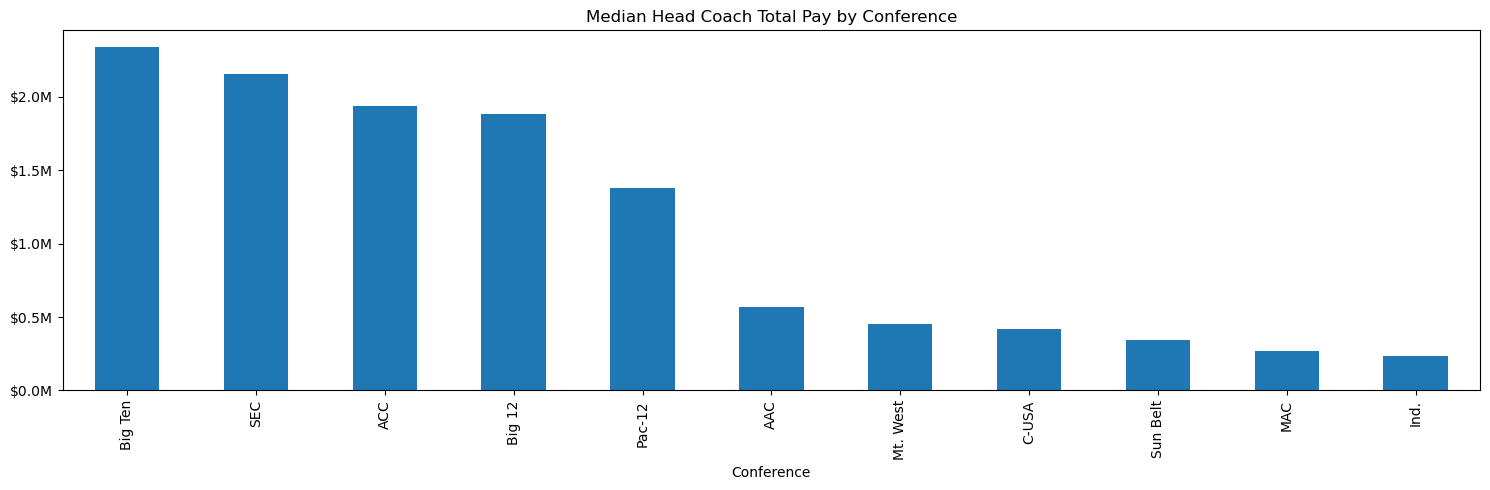

Median Total Pay by Conference
conf
Big Ten    2334467.64
SEC        2157164.87
ACC        1933855.68
Big 12     1880193.89
Pac-12     1381227.53
AAC         566255.78
Mt. West    451611.71
C-USA       417308.68
Sun Belt    346687.21
MAC         267162.56
Ind.        236168.46
Name: totalpay, dtype: float64


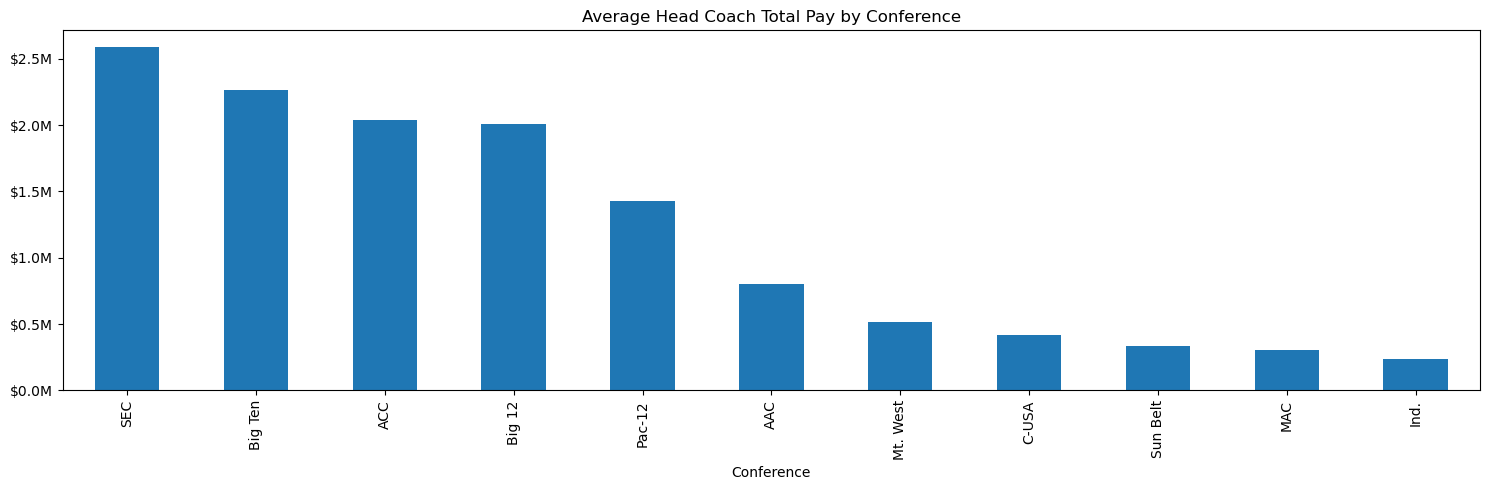


Average Total Pay by Conference
conf
SEC        2584388.85
Big Ten    2263585.73
ACC        2035747.43
Big 12     2010951.72
Pac-12     1424957.63
AAC         801489.47
Mt. West    516660.42
C-USA       417308.68
Sun Belt    337474.32
MAC         308036.98
Ind.        236168.46
Name: totalpay, dtype: float64


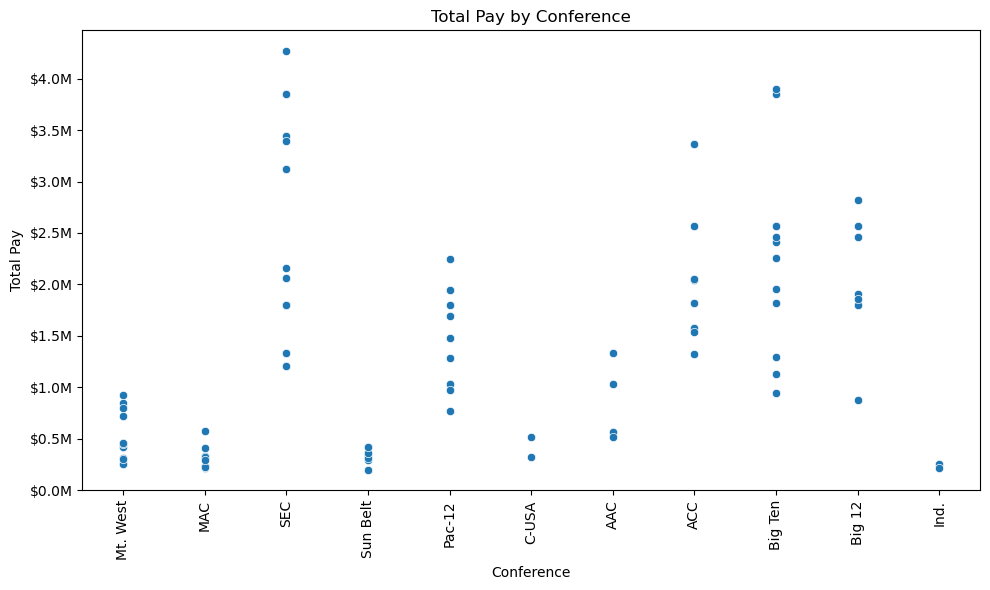

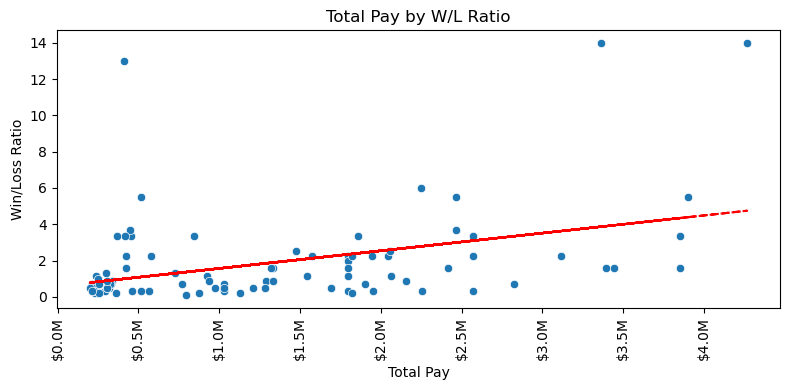

<Figure size 640x480 with 0 Axes>

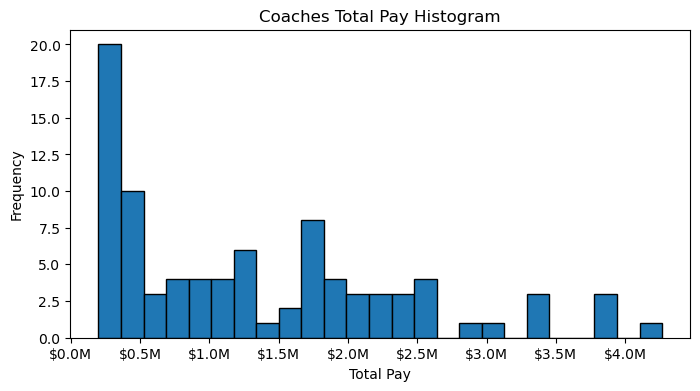

C:\Users\14108\AppData\Local\Temp\ipykernel_6356\2579003599.py:90: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = coaches.corr()


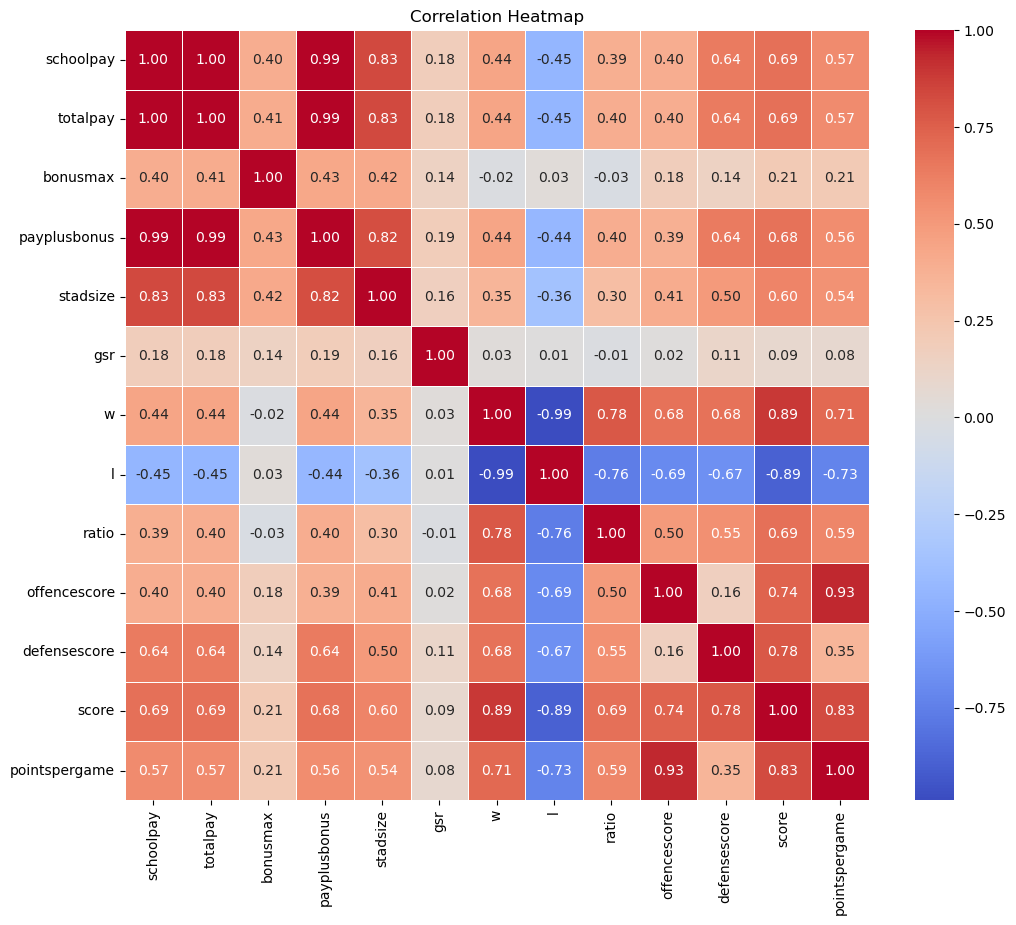

In [24]:
# Top/Bottom 5 coaches totalpay
top = coaches.sort_values(by = 'totalpay', ascending = False).head()
bottom = coaches.sort_values(by = 'totalpay', ascending = True).head()

# Display results
print('Top 5 Highest Paid Coaches')
print(top[['school', 'conf', 'coach', 'totalpay']])
print('\nBottom 5 Lowest Paid Coaches')
print(bottom[['school', 'conf', 'coach', 'totalpay']])


# Run Average and Medians by Conference 
median_by_conference = coaches.groupby('conf')['totalpay'].median().sort_values(ascending = False)
avg_by_conference = coaches.groupby('conf')['totalpay'].mean().sort_values(ascending = False)

# Function for formatting the Y-axis labels 
def millions_format(x, pos):
    return f'${x / 1e6:.1f}M'

# Bar charts of the median and averages by conference 
pt.figure(figsize = (15,5))
mc = median_by_conference.plot(kind = 'bar')
mc.yaxis.set_major_formatter(pt.FuncFormatter(millions_format))
pt.xlabel('Conference')
pt.ylabel('')
pt.title('Median Head Coach Total Pay by Conference')
pt.xticks(rotation = 90)
pt.tight_layout()
pt.show()

print("Median Total Pay by Conference")
print(median_by_conference)


pt.figure(figsize = (15,5))
ac = avg_by_conference.plot(kind = 'bar')
ac.yaxis.set_major_formatter(pt.FuncFormatter(millions_format))
pt.xlabel('Conference')
pt.ylabel('')
pt.title('Average Head Coach Total Pay by Conference')
pt.xticks(rotation = 90)
pt.tight_layout()
pt.show()


print("\nAverage Total Pay by Conference")
print(avg_by_conference)

# Scatter Plot of Coaches Total Pay by Conference 
pt.figure(figsize = (10,6))
sp = sb.scatterplot(data = coaches, x = 'conf', y = 'totalpay')
sp.yaxis.set_major_formatter(pt.FuncFormatter(millions_format))
pt.xlabel('Conference')
pt.ylabel('Total Pay')
pt.title('Total Pay by Conference')
pt.xticks(rotation = 90)
pt.tight_layout()
pt.show()

# Scatter Plot Coahces Total Pay by W/L Ratio 
pt.figure(figsize = (8,4))
sp2 = sb.scatterplot(data = coaches, x = 'totalpay', y = 'ratio')
sp2.xaxis.set_major_formatter(pt.FuncFormatter(millions_format))
pt.xlabel('Total Pay')
pt.ylabel('Win/Loss Ratio')
pt.title('Total Pay by W/L Ratio')
pt.xticks(rotation = 90)
pt.tight_layout()
x = coaches['totalpay']
y = coaches['ratio']
coefficients = np.polyfit(x, y, 1)
trendline = np.poly1d(coefficients)
pt.plot(x, trendline(x), color='red', linestyle='--', label=f'Trendline: {coefficients[0]:.2f}x + {coefficients[1]:.2f}')
#pt.legend()
pt.tight_layout()
pt.show()
pt.tight_layout()
pt.show()

# Histogram of the Total Pay 
pt.figure(figsize = (8,4))
pt.hist(coaches['totalpay'], bins = 25, edgecolor = 'black')
pt.gca().xaxis.set_major_formatter(pt.FuncFormatter(millions_format))
pt.xlabel('Total Pay')
pt.ylabel('Frequency')
pt.title('Coaches Total Pay Histogram')
pt.show()

# Run a correlation test with a heatmap to visually understand matrix
cor = coaches.corr()

pt.figure(figsize = (12,10))
sb.heatmap(cor, annot = True, cmap = 'coolwarm', fmt = '.2f', linewidth = 0.5)
pt.title('Correlation Heatmap')
pt.show()
#print(cor)

Through the initial visualizations of the coaches total pay, there is no significant difference between the median and averages. The first two histograms suggests that there is a signifcant difference of total pay throughout the conferences. The top five highest paid coaches are paid between 3.4 million dollars per year, where the bottom five coaches are in the hundred thousands. 

Unsuprisingly with the top conferences with TV rights and name brands in the last two decades, the SEC, AAC, Big Ten, and Big 12 have the highest paid coaches than a majority of the other conferences. Each conference however has slight dispersion between the lowest paid coaches and the highest paid besides the smaller conferences. 

The next visualization breaks down the win loss record ratio and the amount of total pay for coaches. There is a slight positive relationship between teams that win more, the coaches receive higher annual salaries. There is one outlier where the win loss ratio is quite high but the coaches salary is below a half a million dollars (Western Michigan).

The histogram of coaches total pay regardless of conference visualizes the majority of schools pay their coaches below two million dollars per year. The elite programs like ALabama and Clemson will always tend to pay their coaches more as long as those schools are performing.

To wrap the EDA process, the correlation chart visualizes with a heat map the variables and their correlation. Focusing on total pay as that is the variable that we will focus on in the regression analysis and predictive analytics, the majority of the other pay related variables are highly correlated with total pay. The variable that stands out the most with a high degree of correlation to total pay is stadium size, the larger the stadium the higher the coaches total pay. The losses variable is negatively correlated with total pay, which is quite obvious, a school that does not have a football program that performs well will not pay their coach or they are fired. 

## Regression Analysis

In [25]:
# Creating a new dataframe for regression maintaing original and adding binary dummy variables for the conferences
ra = coaches
dummy = pd.get_dummies(ra['conf'], prefix = 'conf')
ra = pd.concat([ra, dummy], axis = 1)

# Clean up ra dataframe
# Columns to drop, drop column for conference AAC this will be included in the base case of the intercept
ra_columns_drop = ['school','conf','coach','conf_AAC','schoolpay','payplusbonus','bonusmax']
ra.drop(columns = ra_columns_drop, inplace = True)

# Convert column headers to lowercase
ra.columns = ra.columns.str.lower()

# Remove spaces in columns names
ra.rename(columns = lambda x: x.replace(' ', ''), inplace = True)

# Remove special characters from column headers 
ra.columns = ra.columns.str.replace(r'[^a-zA-Z0-9]', '', regex = True)
#ra.head().to_string()

In [26]:
# Regression model 
# Drop totalpay from independent variables 
x = ra.drop(columns = ['totalpay'])
y = ra['totalpay']

# Split the dataframe 70/30
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 11)

x_train = sm.add_constant(x_train)
x_test = sm.add_constant(x_test)

# Fit OLS model to training data 
mod = sm.OLS(y_train, x_train).fit()

# Predict on test set
y_pred = mod.predict(x_test)

# OLS Regression Summary
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:               totalpay   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     9.068
Date:                Mon, 23 Oct 2023   Prob (F-statistic):           2.50e-09
Time:                        16:17:44   Log-Likelihood:                -872.50
No. Observations:                  61   AIC:                             1785.
Df Residuals:                      41   BIC:                             1827.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2.747e+06    3.3e+06     -0.834

In [32]:
# Predict Syracuse Coach totalpay
df = {
    'constant': 1,
    'stadsize': 49250,
    'gsr': 80,
    'w': 4,
    'l': 8,
    'ratio': 0.5,
    'offencescore': 0.08,
    'defensescore': -4.59,
    'score': -4.51,
    'pointspergame': 75.51,
    'confacc': 1,
    'confbig12': 0,
    'confbigten': 0,
    'confcusa': 0,
    'confind': 0,
    'confmac': 0,
    'confmtwest': 0,
    'confpac12': 0,
    'confsec': 0,
    'confsunbelt': 0,
}

cuse = pd.DataFrame(df, index = [0])

pred_total_pay = mod.predict(cuse)

# Print the predicted totalpay for Syracuse
print("Predicted Total Pay for Syracuse:", pred_total_pay.iloc[0])

Predicted Total Pay for Syracuse: 1555783.6388342232


In [28]:
# Predict Syracuse Coach totalpay in the Big Ten 
df = {
    'constant': 1,
    'stadsize': 49250,
    'gsr': 80,
    'w': 4,
    'l': 8,
    'ratio': 0.5,
    'offencescore': 0.08,
    'defensescore': -4.59,
    'score': -4.51,
    'pointspergame': 75.51,
    'confacc': 0,
    'confbig12': 0,
    'confbigten': 1,
    'confcusa': 0,
    'confind': 0,
    'confmac': 0,
    'confmtwest': 0,
    'confpac12': 0,
    'confsec': 0,
    'confsunbelt': 0,
}

cuse = pd.DataFrame(df, index = [0])

pred_total_pay = mod.predict(cuse)

# Print the predicted totalpay for Syracuse
print("Predicted Total Pay for Syracuse:", pred_total_pay.iloc[0])

Predicted Total Pay for Syracuse: 1789686.8425009623


In [ ]:
# Regression model 2 remove high p-values besides the conference dummy variables 
# Drop totalpay from independent variables 
ra2 = ra 
ra2_columns_drop = ['w','l','offencescore','defensescore','score']
ra2.drop(columns = ra2_columns_drop, inplace = True)

In [37]:
# Regression model 2 
x2 = ra2.drop(columns = ['totalpay'])
y2 = ra2['totalpay']

# Split the dataframe 70/30
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size = 0.3, random_state = 11)

x_train2 = sm.add_constant(x_train2)
x_test2 = sm.add_constant(x_test2)

# Fit OLS model to training data 
mod2 = sm.OLS(y_train2, x_train2).fit()

# Predict on test set
y_pred2 = mod2.predict(x_test2)

# OLS Regression Summary
print(mod2.summary())

                            OLS Regression Results                            
Dep. Variable:               totalpay   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     9.788
Date:                Mon, 23 Oct 2023   Prob (F-statistic):           1.46e-09
Time:                        16:21:26   Log-Likelihood:                -880.67
No. Observations:                  61   AIC:                             1791.
Df Residuals:                      46   BIC:                             1823.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.394e+06   1.16e+06     -1.202

In [43]:
# Predict Syracuse Coach totalpay
df = {
    'constant': 1,
    'stadsize': 49250,
    'gsr': 80,
    #'w': 4,
    #'l': 8,
    'ratio': 0.5,
    #'offencescore': 0.08,
    #'defensescore': -4.59,
    #'score': -4.51,
    'pointspergame': 75.51,
    'confacc': 1,
    'confbig12': 0,
    'confbigten': 0,
    'confcusa': 0,
    'confind': 0,
    'confmac': 0,
    'confmtwest': 0,
    'confpac12': 0,
    'confsec': 0,
    'confsunbelt': 0,
}

cuse2 = pd.DataFrame(df, index = [0])

pred_total_pay2 = mod2.predict(cuse2)

# Print the predicted totalpay for Syracuse
print("Predicted Total Pay for Syracuse:", pred_total_pay2.iloc[0])

Predicted Total Pay for Syracuse: 1680106.8815308972


In [44]:
# Predict Syracuse Coach totalpay in the Big Ten 
df = {
    'constant': 1,
    'stadsize': 49250,
    'gsr': 80,
    #'w': 4,
    #'l': 8,
    'ratio': 0.5,
    #'offencescore': 0.08,
    #'defensescore': -4.59,
    #'score': -4.51,
    'pointspergame': 75.51,
    'confacc': 0,
    'confbig12': 0,
    'confbigten': 1,
    'confcusa': 0,
    'confind': 0,
    'confmac': 0,
    'confmtwest': 0,
    'confpac12': 0,
    'confsec': 0,
    'confsunbelt': 0,
}

cuse = pd.DataFrame(df, index = [0])
pred_total_pay = mod2.predict(cuse)

# Print the predicted totalpay for Syracuse
print("Predicted Total Pay for Syracuse:", pred_total_pay.iloc[0])

Predicted Total Pay for Syracuse: 1848360.922865789


Two regression models were ran to predict a coaches salary based on a number of variables. In the first model, a handful of pay related variables that showed high correlation in the EDA were dropped and the conference dummy variable AAC as is included in the base case. The Adjusted R-Squared in the first model was at 71.9%, where almost 72% of the variablity in the dependent variable is explained by the independent variables. There is also a low F-statistic below a 5% threshold, suggesting a statistically significant model. However the coeffecients in this model's p-values suggest that a majority of the values are not statistically signficant at a 5% threshold.

The coeffiecents in the first model suggest that the variables that influence total pay are scoring (offencesscore, defensesscore, and score) all have positive increases to salary. 

Utilizing the regression model, we can predict that the total pay for Syracuse University's coach should be around \\$1,555,783 per year as the school is currently in the ACC conference. If Syracuse was in the Big Ten, the coach's salary would increase to \\$1,789,686 per year. From the scatterplot above in the EDA portion of the analysis shows that the pay is slightly higher in the Big Ten compared to the ACC. 

The second model was limited to variables that did not have high p-values and left in the dummy variables for the conferences as these were needed to answer whether or not there was a difference in pay between conferences. From the EDA there is a variation between conferences and the coaches total pay. With the second regression models the p-values of the coefficents slightly decreased, as a result the Adjusted R-square also decreased to 67.2%, the model's F-statistic is still below a 5% threshold and is considered statistically significant. 

The second model shows that with scoring removed as avariable, GSR and the Big Ten conference dummy variables have the highest positive influence on salary

From the second regression model, we run the same predictions for Syracuse University's head coaching position. Each prediction whether the school is playing the current ACC conference or Big Ten increased the predicted salary, \\$1,680,106 & \\$1,848,360 respectively. 

From USA Today, Dino Baber's first reported salary in 2018 was \\$2,401,206 per year and has slightly increased with each year he has been coaching at Syracuse. Both regression models were off in predicting the correct salary, but no model is perfect and can be fine tuned with more historical data and training. 

https://sports.usatoday.com/ncaa/salaries/football/coach/team/104 

## Conclusion

Using the OSEMiN data science process, we were able to clean, create, explore, model, and revise a data set to predict a NCAA Divisions I Coach's salary based on various factors. 

However, more historical data is required to accurately try and predict the total pay for a coach. Historical attributes for example; team's win/loss record under the current coach, assistant head coach salary, number of bowl game appearances, and national titles could assist in predicting a salary. 